$\textbf{Introduction}$

In this segment, we will examine the use of the LASSO with cross-validation for both artificailly generated data as well as actual data.  We will not test hypothesis but we will see how the Elastic Net/LASSO and Cross-Validation methods help to destroy useless coefficients.
As discussed in the lecture, the minimization problem for estimation puts a penalty on the size of the estimated parameters.

The estimation problem is to minimize the penalize sum of squred errors, with the penality based on the sum of the parameters, either in absolue or in squared values:


$\beta_{Enet}=\stackrel{Min}{\beta}\left\{ \sum_{t=1}^{T}\left(y_{t}-\sum_{i}\beta_{i}x_{it}\right)^{2}+\lambda\sum_{i=1}^{k}\left[\left(\alpha|\beta_{i}|\right)+(1-\alpha)\beta_{i}^{2}\right]\right\}$

The parameters  $\alpha$ and $\lambda$ are $\textit{hyper-parameters}$.   With $\alpha=1$ the problem is to minimize the sume of absolute values of the estimate coefficients, and with $\alpha=0$ the problem is to minimize the sum of squares of the estimated programs.  The former is called LASSO estimation, while the latter is called Ridge regression.   Elastic net estimation implies a value of $\alpha$ between 0 and 1.   We will set the hyperparameter $\alpha=.5$.

The problem is to find the right value of $\lambda$ for minimizing the penalized sum-of-squared errors.

The method of Cross-Valiation works in the following way:
• In this approach, we select a grid of values for $\lambda$, between $\lambda=0$, and $\lambda^{*}$, the minimum $\lambda$ which sets all of the coefficients $\beta_{i}=0$.

• We then select a set of out-of-sample Mean Squared Error measures, based on holding out 20% of the sample for each specified $\lambda$ over the grid. 

• We thus select the optimal $\lambda$ as the one which minimizes the average out-of-sample mean squared error, based on five sets of hold-outs of 20% of the data. 

• We note that the coefficients $\left\{ \beta_{i}\right\}$  are based on the full in-sample elastic-net estimation with the pre-specified tuning parameter, $\alpha$, 

• We obtain the final optimal value of $\lambda$ from the cross-validation method. 







$\textbf{Monte Carlo Experiment}$

Our first example is a simple Monte Carlo experiment  We will make use of a Matlab built-in function called LASSO wiht the CV option.  But other LASSO programs can be used as well.
We basically generate random data, for both the dependent variable and the indepenent variabls.  Of course, the coefficints should be zero.  But they will not be exactly zero.

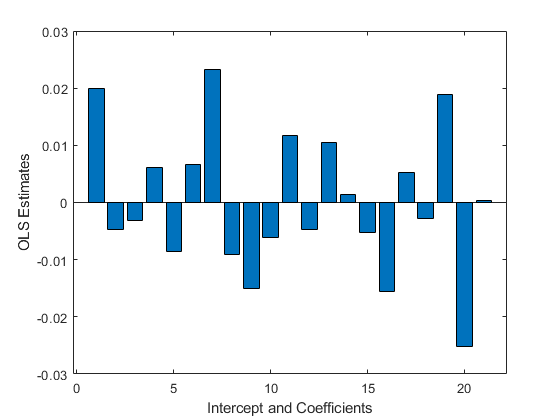

In [1]:
% Montecarlo Experiment
y = randn(5000,1);
xx = randn(5000,20);
xx = [ones(5000,1) xx];
B = regress(y,xx); 
bar(B); xlabel('Intercept and Coefficients'); ylabel('OLS Estimates');

You can see that the estimation from the randomly-generated data gives coefficients which are not zero.  Of course they are not statistically significant but we are not interested in doing statistical tests.  We want to use the EN-Lasso method to get rid of these useless coefficient.

Now let's estimate the coefficients with the LASSO method.

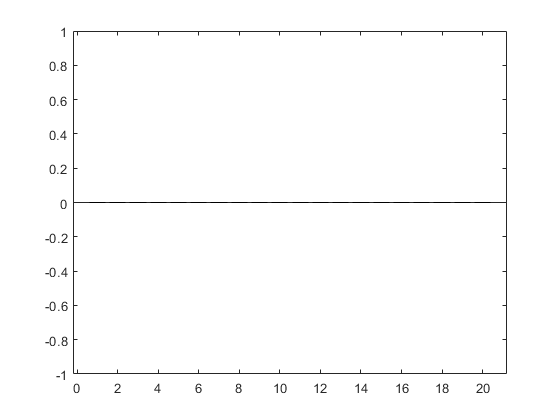

In [3]:
nfolds = 20;

[B,S] = lasso(xx(:,2:end),y,'Alpha', .5, 'CV',nfolds);
lasso_col = min(S.IndexMinMSE);
BETA = B(:,lasso_col);
bar(BETA)



In the above Bar chart, we plot the coefficients using OLS and LASSO, with $\alpha=1$.  You see that LASSO is ruthless, it kills off the useless coefficients.  Not because they are statistically insignificant but because they are useless for out-of-sample prediction. So in Machine Learning we are interested in finding the best set of coefficients for $\textit{out-of-sample prediction}$.  

$\textbf{Forecasting SP500 Returns}$

Now lets read in or import to Matlab SP500 data since 1927 from an Excel Spreadsheet. We will see how we can find coefficints for forecasting returns. We have data on opening, closing, high and low from Yahoo finance. 

In [4]:
clear all;
close all;
Tab = readtable('SP500.xlsx');
date1 = Tab(:,1);
open = Tab(:,2);
high = Tab(:,3);
low = Tab(:,4);
close1 = Tab(:,5);
adjclose1 = Tab(:,6);   % This is the adjusted closing value
date1 = table2array(date1);
open = table2array(open);
high = table2array(high);
low = table2array(low);
close1 = table2array(close1);
adjclose1 = table2array(adjclose1);



Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.



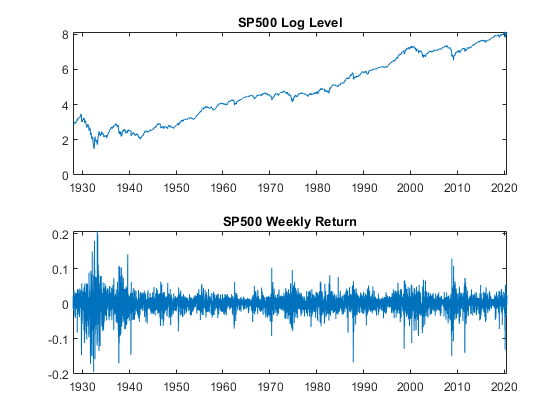

In [5]:
index = 1:5:length(adjclose1);
index1 = index';
Close1 = adjclose1(index1,:);
date2 = date1(index1,:);
plot(date2, Close1); grid;
date3 = date2(2:end);
LClose = log(Close1);
Return = diff(log(Close1));
subplot(211); plot(date2, LClose); title('SP500 Log Level'); ...
    subplot(212); plot(date3, Return); title('SP500 Weekly Return');

We see in the above figures the upward spiral of the weekly SP500 index since 1925.  We also see the recurring periods of voaltlity in this index, at the times of the Great Depression in the 1930's, at the time of the Oil Shocks in the 1970's,, at the time of the 911 attack after 2000, and at the time of the Global Financial Crisis in 2008.

Now leets estimate the model with the AR estimation program for a lag of 20 weeks.  

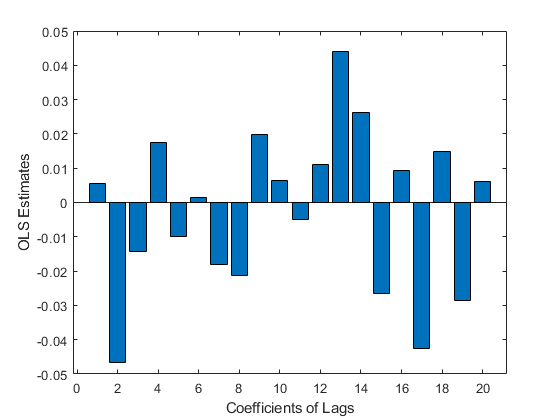

In [6]:
Model = ar(Return, 20);
Pvec = getpvec(Model);
bar(Pvec); xlabel('Coefficients of Lags'); ylabel('OLS Estimates');

We see ups and downs of the coefficients.  Which ones really matter?
We use the function mlag to create a vector of x's variables which are lags of the Return.
Then create a dependent variable yy.  We use the glmnet programs cvglmnet (cross-validation glmnet) and obtain the Beta (coefficient vector) from the best out-of-sample error.  Looking at the Bar chart of the Lasso coefficients, we see that it kills off a lot.

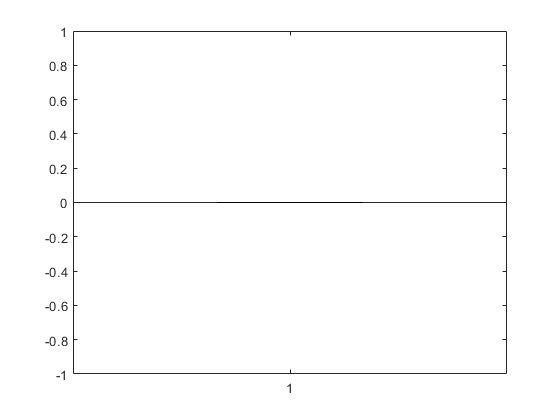

In [8]:
xx = lagmatrix(Return,20);
yy = Return(21:end,:);
xx = xx(21:end,:);
nfolds = 20;

[B,S] = lasso(xx,yy,'Alpha', .5, 'CV',nfolds);
lasso_col = min(S.IndexMinMSE);
BETA = B(:,lasso_col);
bar(BETA)


$\textbf{Forecasting SP500 Volatility}$

Now let's see if we can forecast the range volatility.  We calculate it from the high, low, opening and closing values of the daily indices.  We are shifting to daily, not weekly, frequency.
For the logarithm of the high, low, opening and adjusted closing values, we calculate the Range Volatility:

$\hat{\sigma_{t}^{R}=.511(h-l)^{2}-.019[(c-o)(h-l-2o)}-2(h-o)(l-o)]-.383(c-o)^{2}$


In [9]:
Data = [open high low adjclose1];
RangeVol = rangefun(Data);
date4 = date1(10000:end,:);
RangeVol1 = RangeVol(10000:end,:);

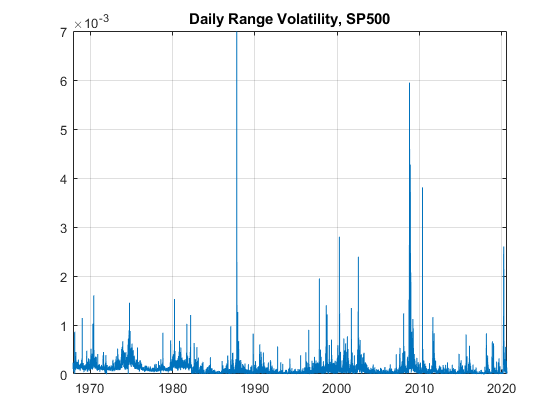

In [19]:
plot(date4, RangeVol1); grid; title('Daily Range Volatility, SP500');

For simplicity we will only use data since the late 60's.  We see spikes at the time of the oil shocks, at the time of the Gulf War, at the time of 911 in 2001, and in 2008 at the time of the Global Financial Crisis and in 2020 at the time of the COVID19 Pandemic.
Let's first estimate the coefficients with the AR process.

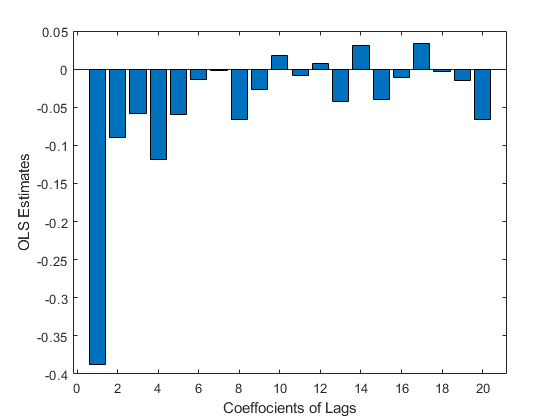

In [10]:
Model1 = ar(RangeVol1,20);
Pvec1 = getpvec(Model1);
bar(Pvec1); xlabel('Coeffocients of Lags'); ylabel('OLS Estimates');


We see that the AR lags move around quite a bit.   Now what happens if we use LASSO?

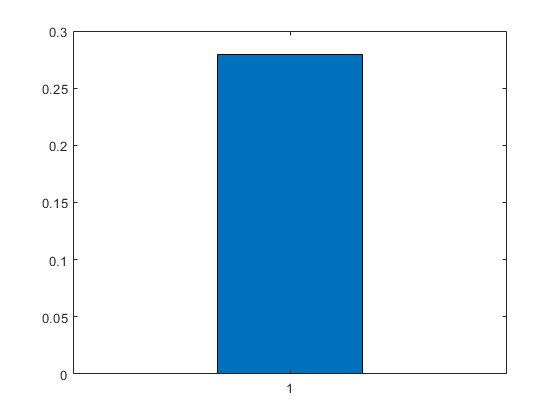

In [11]:
xxx =  lagmatrix(RangeVol1, 20);
xxx = xxx(21:end,:);
yyy = RangeVol1(21:end,:);
nfolds = 20;
[B,S] = lasso(xxx,yyy,'Alpha', .5, 'CV',nfolds);
lasso_col = min(S.IndexMinMSE);
BETA = B(:,lasso_col);
bar(BETA)


We see that the LASSO estimation gets ride of a lot of the coefficients after period 10 and switches their sign.

The LASSO estimation tells us we need to only look at the data for the past five or six days to forecast the range volatility.